In [1790]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1791]:
data = pd.read_csv("./players_fifa23_cleaned.csv")
data.head()

,ID,Name,FullName,Age,Height,Weight,PhotoUrl,Nationality,Overall,Potential,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,158023,L. Messi,Lionel Messi,35,169,67,https://cdn.sofifa.net/players/158/023/23_60.png,Argentina,91,91,...,91,88,91,67,66,67,62,53,62,22
1,165153,K. Benzema,Karim Benzema,34,185,81,https://cdn.sofifa.net/players/165/153/23_60.png,France,91,91,...,89,84,89,67,67,67,63,58,63,21
2,188545,R. Lewandowski,Robert Lewandowski,33,185,81,https://cdn.sofifa.net/players/188/545/23_60.png,Poland,91,91,...,86,83,86,67,69,67,64,63,64,22
3,192985,K. De Bruyne,Kevin De Bruyne,31,181,70,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,91,91,...,91,91,91,82,82,82,78,72,78,24
4,231747,K. Mbappé,Kylian Mbappé,23,182,73,https://cdn.sofifa.net/players/231/747/23_60.png,France,91,95,...,92,84,92,70,66,70,66,57,66,21


<h3>Extracting players with overall above 86:</h3>

In [1795]:
X_clus = data[data.Overall > 86] 
X_clus.shape

(43, 80)

In [1796]:
names = X_clus["Name"].tolist() # saving names for later

X_clus = X_clus.drop(['Name'], axis = 1)

<h3>Feature Scaling:</h3>

In [1797]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X_clus = mms.fit_transform(X_clus)

<h3>Perform Dimentionality Reduction:</h3>


In [1798]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) # Reduce the Dimention of the Data to its half

X_clus = pd.DataFrame(pca.fit_transform(X_clus))

<h2>Clustering:</h2>

<h3>1. KMeans:</h3>

<h4>Use the Elbow function to determine the optimal number of Clusters:</h4>

In [1799]:
import random
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

visualizer = KElbowVisualizer(KMeans(), timings=False)

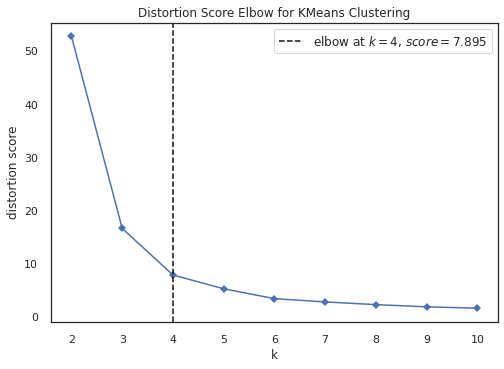

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1800]:
visualizer.fit(X_clus)
visualizer.show()

<h4>So the Optimal number of clusters is 4</h4>

In [1801]:
kmeans = KMeans(n_clusters=4)

kmeans = kmeans.fit(X_clus)

# get the cluster labels
labels = kmeans.predict(X_clus)

# cluster values
kmeans_clusters = kmeans.labels_.tolist()

In [1802]:
X_kmeans = X_clus.copy()
X_kmeans['cluster'] = kmeans_clusters
X_kmeans['name'] = names
X_kmeans.columns = ['x', 'y', 'cluster', 'name']
X_kmeans.head()

,x,y,cluster,name
0,-1.454918,-1.884138,0,L. Messi
1,-1.197165,-1.394994,0,K. Benzema
2,-1.339649,-1.340175,0,R. Lewandowski
3,-1.926870,-0.572596,3,K. De Bruyne
4,-1.546036,-1.581132,0,K. Mbappé


<h3>Plot the Clusters of the K-means Algorithm:</h3>

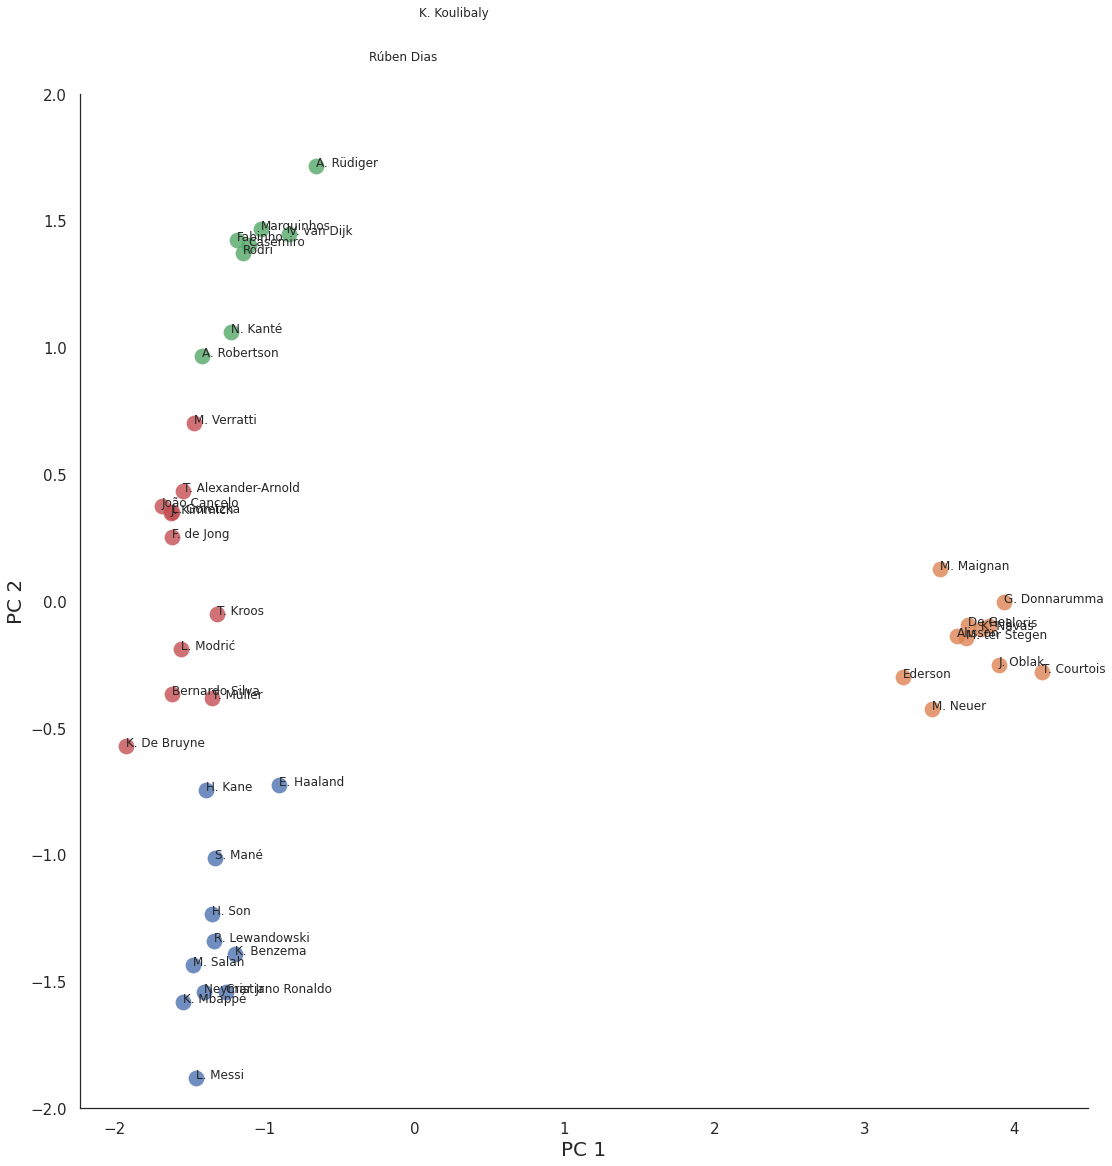

In [1803]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_kmeans, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_kmeans.x, X_kmeans.y, X_kmeans.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the K-means algorithm using Silhouette coefficient:</h3>

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. The score is bounded between <b>-1 for incorrect clustering and +1 for highly dense clustering</b>. </br>
Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated.

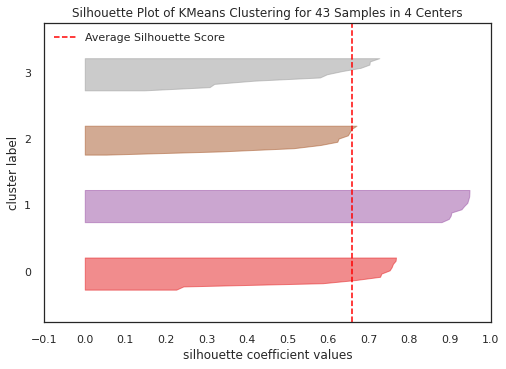

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 43 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [1804]:
sil_visualizer = SilhouetteVisualizer(kmeans)
sil_visualizer.fit(X_clus)    
sil_visualizer.show()

In [1805]:
silhouette_score(X_clus, kmeans.labels_)

0.6586684841017966

<h3>2. Hirerichal Clustering:</h3>

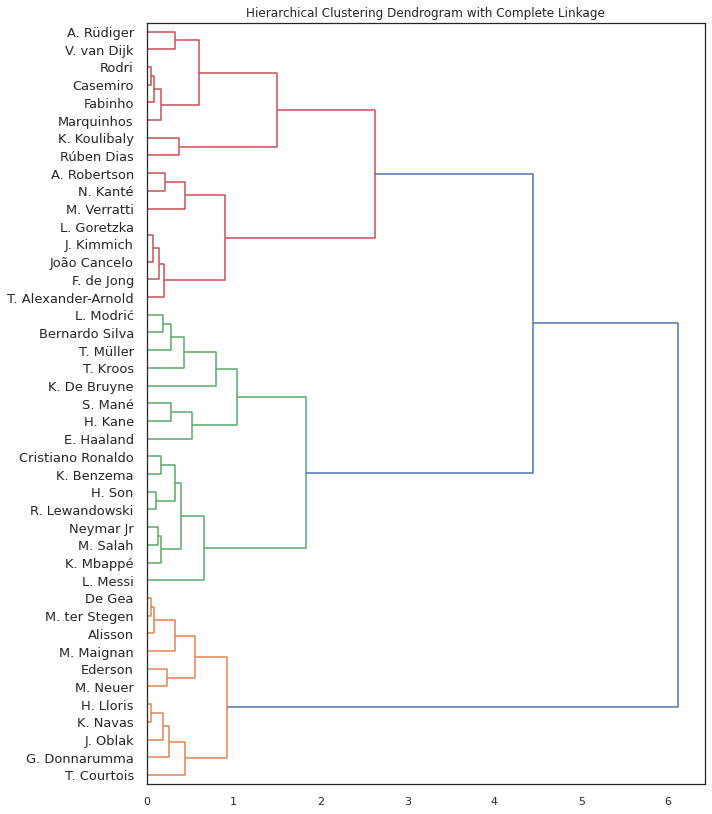

In [1806]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# plot dendrogram using complete linkage
plt.figure(figsize=(10,14))
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')

dendrogram = sch.dendrogram(sch.linkage(X_clus, method="complete"), labels= names, leaf_font_size = 13, orientation='right')

In [1807]:
unique_colors = set(dendrogram['color_list'])
num_clusters_hir = len(unique_colors)-1
print("Optimal number of clusters is : ", num_clusters_hir)

Optimal number of clusters is :  3


In [1808]:
from sklearn.cluster import AgglomerativeClustering
cluster_hir = AgglomerativeClustering(n_clusters=num_clusters_hir, affinity='euclidean', linkage='ward')
cluster_hir.fit_predict(X_clus)

# cluster values
hir_clusters = cluster_hir.labels_.tolist()

In [1809]:
print("Estimated number of noise points:", list(cluster_hir.labels_).count(-1))

Estimated number of noise points: 0


In [1810]:
X_hir = X_clus.copy()
X_hir['cluster'] = hir_clusters
X_hir['name'] = names
X_hir.columns = ['x', 'y', 'cluster', 'name']
X_hir.head()

,x,y,cluster,name
0,-1.454918,-1.884138,2,L. Messi
1,-1.197165,-1.394994,2,K. Benzema
2,-1.339649,-1.340175,2,R. Lewandowski
3,-1.926870,-0.572596,2,K. De Bruyne
4,-1.546036,-1.581132,2,K. Mbappé


<h3>Plot the Clusters of the Hirerichal Clustering Algorithm:</h3>

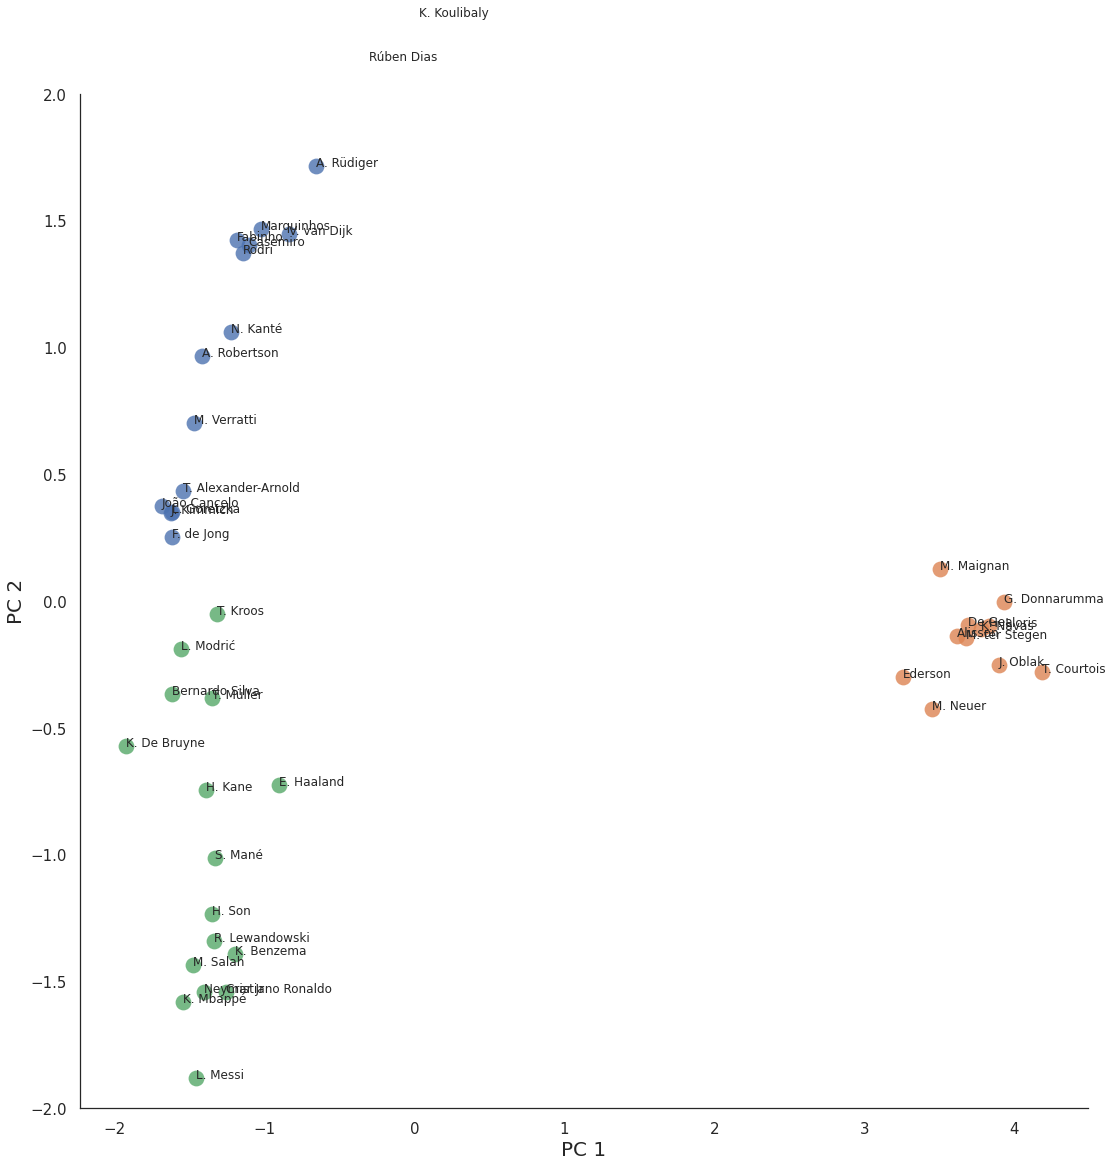

In [1811]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_hir, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_hir.x, X_hir.y, X_hir.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the Hirerichal Clustring algorithm using Silhouette coefficient:</h3>

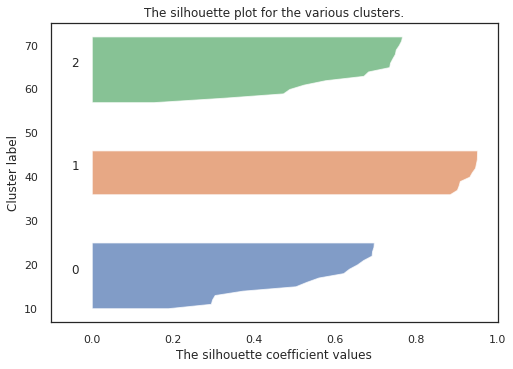

In [1812]:
cluster_labels = cluster_hir.labels_
silhouette_avg = silhouette_score(X_clus, cluster_hir.labels_)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_clus, cluster_labels)

fig, ax1 = plt.subplots(1)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])


y_lower = 10
for i in range(num_clusters_hir):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                     alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


plt.show()

In [1813]:
silhouette_score(X_clus, cluster_hir.labels_)

0.6617483192694013

<h3>3. Density-based clustering (DBSCAN):</h3>

In [1814]:
from sklearn.cluster import DBSCAN

# train the model using DBSCAN
db = DBSCAN(eps=0.429, min_samples=5)
db.fit_predict(X_clus)

# prediction for dbscan clusters
db_clusters = db.labels_.tolist()

In [1815]:
print("Number of Cluster in the Density Based Clustering:", len(set(db_clusters)))

Number of Cluster in the Density Based Clustering: 6


In [1816]:
X_db = X_clus.copy()
X_db['cluster'] = db_clusters
X_db['name'] = names
X_db.columns = ['x', 'y', 'cluster', 'name']
#X_db["cluster"][X_db["cluster"] == -1] = 4
X_db.head()

,x,y,cluster,name
0,-1.454918,-1.884138,0,L. Messi
1,-1.197165,-1.394994,0,K. Benzema
2,-1.339649,-1.340175,0,R. Lewandowski
3,-1.926870,-0.572596,-1,K. De Bruyne
4,-1.546036,-1.581132,0,K. Mbappé


<h3>Plot the Clusters of the DBSCAN Clustering Algorithm:</h3>

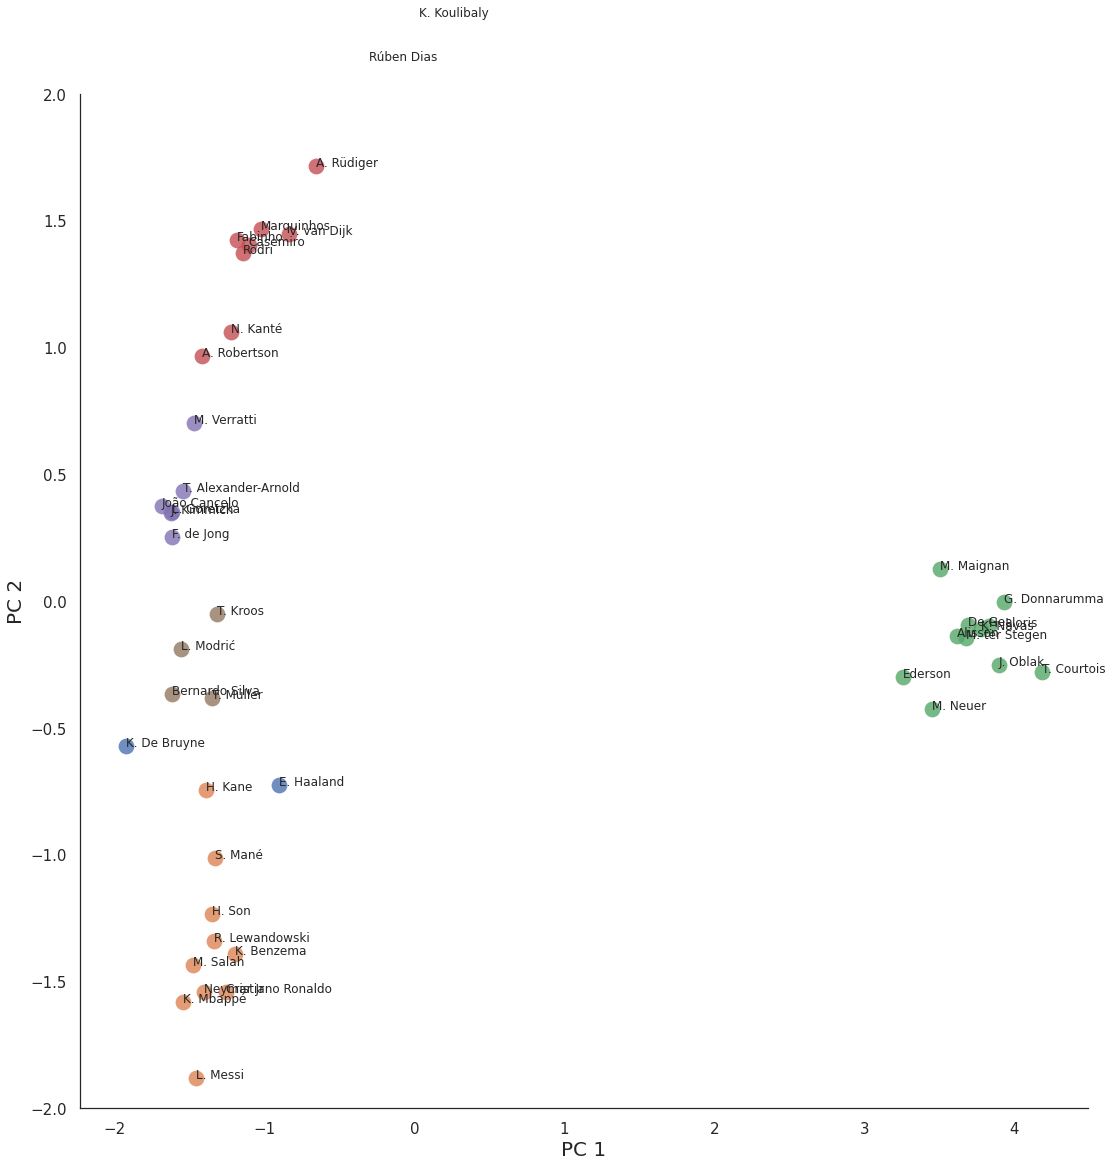

In [1817]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_db, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_db.x, X_db.y, X_db.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the DBSCAN Clustring algorithm using Silhouette coefficient:</h3>

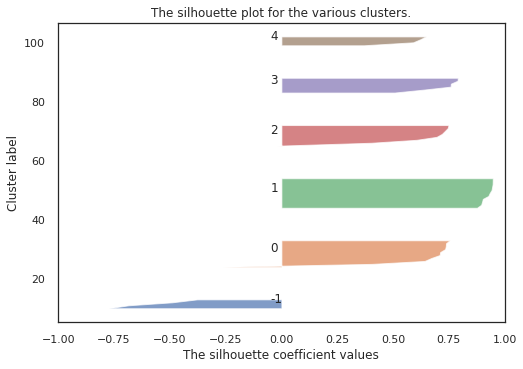

In [1818]:
cluster_labels = db.labels_
silhouette_avg = silhouette_score(X_clus, db.labels_)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_clus, cluster_labels)
fig, ax1 = plt.subplots(1)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-1, 1])

num_clusters = len(set(db_clusters))
y_lower = 10
for i in range(-1, num_clusters-1):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                     alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

plt.show()

In [1819]:
silhouette_score(X_clus, db.labels_)

0.5760147964369781

<h3>4. Distribution-based clustering:</h3>

In [1820]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
gmm.fit(X_clus)

gmm_clusters = gmm.predict(X_clus).tolist()

In [1821]:
X_gmm = X_clus.copy()
X_gmm['cluster'] = gmm_clusters
X_gmm['name'] = names
X_gmm.columns = ['x', 'y', 'cluster', 'name']
X_gmm.head()

,x,y,cluster,name
0,-1.454918,-1.884138,3,L. Messi
1,-1.197165,-1.394994,3,K. Benzema
2,-1.339649,-1.340175,3,R. Lewandowski
3,-1.926870,-0.572596,2,K. De Bruyne
4,-1.546036,-1.581132,3,K. Mbappé


<h3>Plot the Clusters of the Distribution-based Clustering Algorithm:</h3>

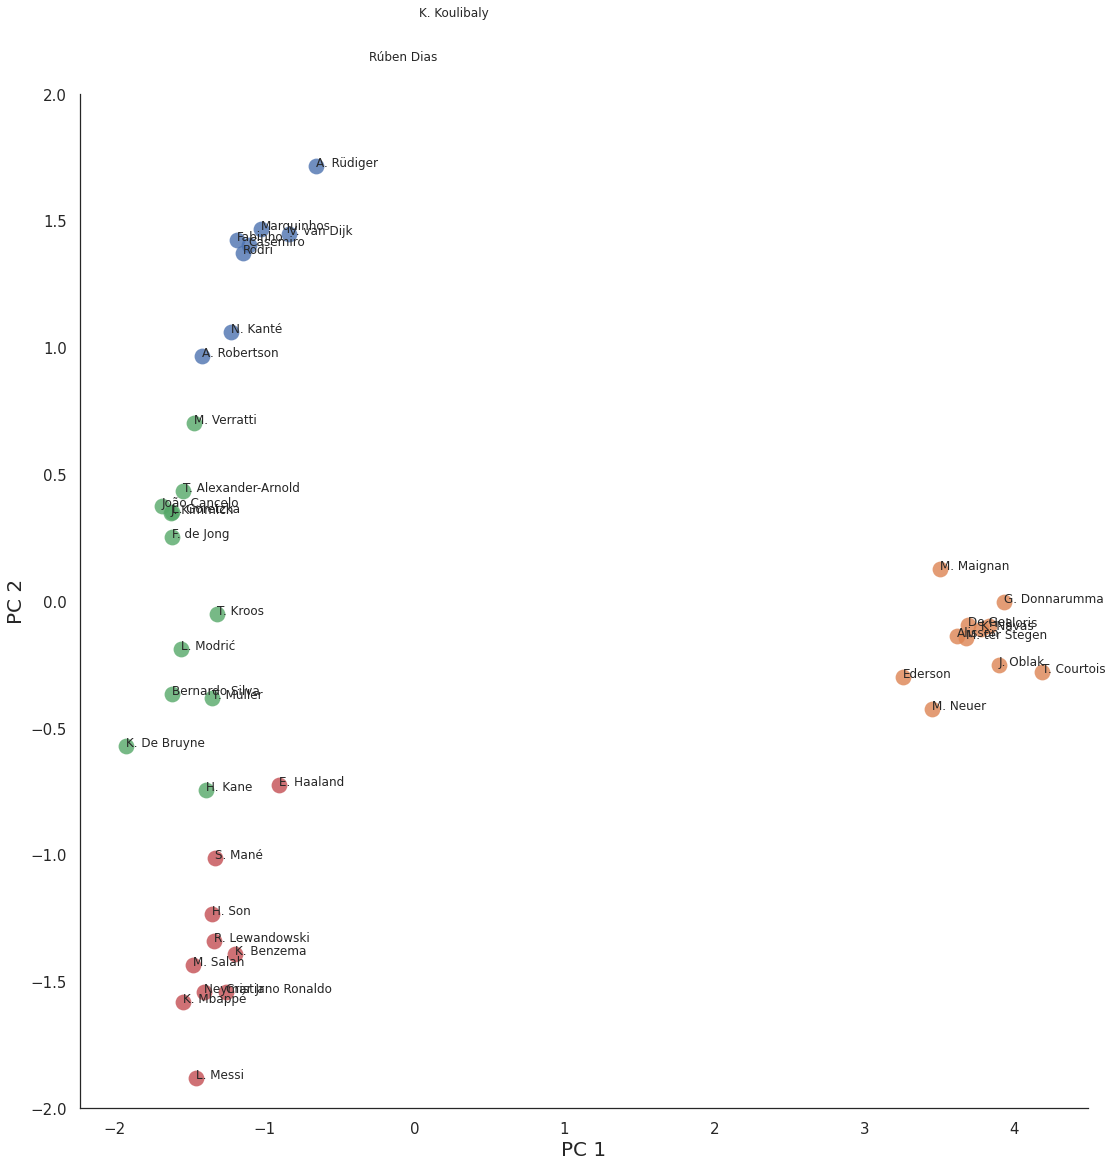

In [1822]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_gmm, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_gmm.x, X_gmm.y, X_gmm.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the Distribution-based Clustring algorithm using Silhouette coefficient:</h3>

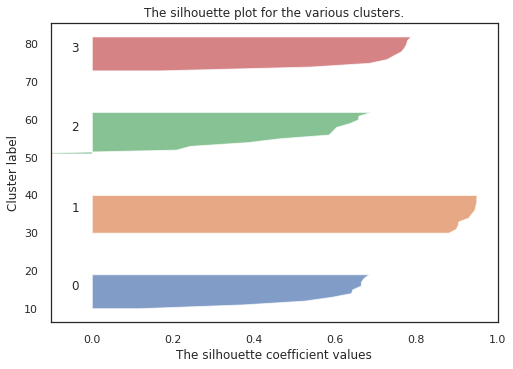

In [1823]:
cluster_labels = np.array(gmm_clusters)
silhouette_avg = silhouette_score(X_clus, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_clus, cluster_labels)
fig, ax1 = plt.subplots(1)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])

num_clusters = len(set(gmm_clusters))
y_lower = 10
for i in range(num_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                     alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

plt.show()

In [1824]:
silhouette_score(X_clus, cluster_labels)

0.6499688092298105